In [1]:
cd ../Build

/home/toby/src/oftnai/Spike-experiments/Build


In [122]:
%run ../Python/PageHD1.py
%matplotlib notebook

import hyperopt
import toml

rate_buf_ival = 2**-6

N_PLACE = 200
N_PLACExFVxHD = 600

expt = "PLACE_proximal-only2"
expt_path = "/home/toby/src/oftnai/Spike-experiments/Build/Examples/" + expt
cwd = "/home/toby/src/oftnai/Spike-experiments/Build/pandapics"
outdir = cwd + "/" + expt

In [27]:
toml_file = "/home/toby/src/oftnai/Spike-experiments/Examples/toml/" + expt + ".toml"
params = toml.load(open(toml_file))
params

{'FVxHD_PLACExFVxHD_scaling': 20.0,
 'PLACE_PLACExFVxHD_scaling': 45.67,
 'PLACE_inhibition': 0.0,
 'PLACExFVxHD_PLACE_scaling': 0.0,
 'PLACExFVxHD_inhibition': -0.25,
 'VIS_PLACE_INH_scaling': -0.00077,
 'VIS_PLACE_scaling': 0.5,
 'test_off_time': 0.0,
 'test_on_time': 0.0,
 'train_time': 60.0}

In [125]:
import time, subprocess

train_time = 80
loss_window = 15

start_t = train_time - (loss_window+1)
stop_t = start_t + loss_window
start_i = int(start_t/rate_buf_ival)
stop_i = int(stop_t/rate_buf_ival)

target_Rmax = 92
target_sparsity = 2.5

eval_num = 0
tried = []
def objective(new_params):
    global target_Rmax, target_sparsity, eval_num, tried, toml_file, expt, cwd, outdir, N_PLACE, N_PLACExFVxHD, start_i, stop_i

    eval_num += 1

    # Save params to toml file:
    params = toml.load(open(toml_file))
    params['PLACE_inhibition'] = float(new_params[0])
    params['PLACExFVxHD_PLACE_scaling'] = float(new_params[1])
    params['PLACExFVxHD_inhibition'] = float(new_params[2])
    params['train_time'] = float(train_time)
    toml.dump(params, open(toml_file, 'w'))

    # Run simulation (accounting for weird VIS bug):
    status = hyperopt.STATUS_OK
    while True:
        result = None
        try:
            subprocess.run(["find", outdir] + "-name simulation.lock -exec rm {} +".split(' '))
            result = subprocess.run([expt_path, toml_file], cwd=cwd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
            status = hyperopt.STATUS_OK
            break
        except subprocess.CalledProcessError as e:
            status = hyperopt.STATUS_FAIL
            # Hackily deal with weird VIS bug:
            params['train_time'] = float(params['train_time'] + 0.1)
            toml.dump(params, open(toml_file, 'w'))
            # print(e)

    # Compute loss:
    sparsity_PLACE, Rmax_PLACE = np.inf, np.inf
    sparsity_PLACExFVxHD, Rmax_PLACExFVxHD = np.inf, np.inf
    if (status == hyperopt.STATUS_OK):
        try:
            R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start_i:stop_i]
            sparsity_PLACE = np.mean(R_PLACE) * 100
            Rmax_PLACE = np.max(R_PLACE) * 100
            
            R_PLACExFVxHD = read_rates(outdir, 'PLACExFVxHD', N_PLACExFVxHD)[:, start_i:stop_i]
            sparsity_PLACExFVxHD = np.mean(R_PLACExFVxHD) * 100
            Rmax_PLACExFVxHD = np.max(R_PLACExFVxHD) * 100
        except ValueError:
            status = hyperopt.STATUS_FAIL
            pass
    loss = ((target_Rmax-Rmax_PLACE)**2 + (8*(target_sparsity-sparsity_PLACE))**2
            + (target_Rmax-Rmax_PLACExFVxHD)**2 + (8*(target_sparsity-sparsity_PLACExFVxHD))**2)
    
    # Print diagnostics:
    print(eval_num, status, (sparsity_PLACE, Rmax_PLACE), (sparsity_PLACExFVxHD, Rmax_PLACExFVxHD), '\n', loss, new_params)
    tried.append((loss, (sparsity_PLACE, Rmax_PLACE), (sparsity_PLACExFVxHD, Rmax_PLACExFVxHD), new_params))
    tried = sorted([x for x in tried if not np.isinf(x[0])], key=lambda x: x[0])
    if eval_num > 3:
        for _ in range(3): print(tried[_])
    print('\n')

    return {
        'loss': loss,
        'status': status,
        'eval_time': time.time(),
        }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective,
    space=[hyperopt.hp.uniform('PLACE_inhibition', -0.1, 0),
           hyperopt.hp.uniform('PLACExFVxHD_PLACE_scaling', 0.1, 1.1),
           hyperopt.hp.uniform('PLACExFVxHD_inhibition', -1, 0),
           #hyperopt.hp.uniform('VIS_PLACE_scaling', 1.2, 1.3),
           #hyperopt.hp.uniform('VIS_PLACE_INH_scaling', -0.003, -0.0025)
          ],
    algo=hyperopt.tpe.suggest,
    max_evals=200,
    trials=trials)

print(best)

1 ok (100.0, 100.0) (73.97260665893555, 100.0) 
 935461.3441678667 (-0.0148540564866399, 1.0851726412025273, -0.21725893139354935)


2 ok (4.506834968924522, 99.7536838054657) (2.6353055611252785, 99.99998807907104) 
 383.04384981208165 (-0.05198412401178726, 0.21165331836425574, -0.5931464608285828)


3 ok (10.684435069561005, 99.90220665931702) (11.517267674207687, 99.99998807907104) 
 9617.394677186774 (-0.06814629430409426, 0.5400676387288256, -0.18299214204254388)


4 ok (10.516002029180527, 99.89495873451233) (4.350023716688156, 99.99998807907104) 
 4457.77826486957 (-0.017735766571497752, 0.25179676373701243, -0.7559324384585787)
(383.04384981208165, (4.506834968924522, 99.7536838054657), (2.6353055611252785, 99.99998807907104), (-0.05198412401178726, 0.21165331836425574, -0.5931464608285828))
(4457.77826486957, (10.516002029180527, 99.89495873451233), (4.350023716688156, 99.99998807907104), (-0.017735766571497752, 0.25179676373701243, -0.7559324384585787))
(9617.394677186774, (

16 ok (37.87553310394287, 99.9919056892395) (14.254774153232574, 99.99999403953552) 
 89062.4661592047 (-0.004471583273853358, 0.3781782806270737, -0.5755753366033761)
(160.5689312118535, (3.1748101115226746, 99.48574304580688), (2.9218481853604317, 99.99998807907104), (-0.08424396577477183, 0.2118955553490273, -0.2987807595417582))
(202.76520003868663, (3.0647598206996918, 99.41281080245972), (1.5046781860291958, 99.99998807907104), (-0.08384327633117933, 0.3226427672906448, -0.8877312446809401))
(383.04384981208165, (4.506834968924522, 99.7536838054657), (2.6353055611252785, 99.99998807907104), (-0.05198412401178726, 0.21165331836425574, -0.5931464608285828))


17 ok (66.18384718894958, 99.99858140945435) (24.695849418640137, 100.0) 
 291218.4172533912 (-0.0006154525769020425, 0.4684540533135555, -0.5356173745222587)
(160.5689312118535, (3.1748101115226746, 99.48574304580688), (2.9218481853604317, 99.99998807907104), (-0.08424396577477183, 0.2118955553490273, -0.2987807595417582))
(2

29 ok (8.217252790927887, 99.90314841270447) (9.662162512540817, 99.99998807907104) 
 5501.4068493092445 (-0.08961479251902238, 0.6124842435072383, -0.1647703783696519)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.3446828915882406))
(136.8014725747417, (3.031066805124283, 99.39917325973511), (2.4922404438257217, 99.99998807907104), (-0.07678082231035334, 0.10799690522374396, -0.37471458313488326))
(145.43705719091872, (3.0907155945897102, 99.41703677177429), (2.247130870819092, 99.99998807907104), (-0.08060548513406524, 0.1910428743437528, -0.4652456248462675))


30 ok (5.857144296169281, 99.84508156776428) (3.104843571782112, 99.99998807907104) 
 870.2653426543508 (-0.04747237585209869, 0.3728421967456894, -0.6422716029079805)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.344682891588240

42 ok (99.87311363220215, 99.9998390674591) (46.56911790370941, 99.99999403953552) 
 731239.0636491486 (-0.02110519281203393, 0.9820171106912906, -0.4013436613448712)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.3446828915882406))
(136.8014725747417, (3.031066805124283, 99.39917325973511), (2.4922404438257217, 99.99998807907104), (-0.07678082231035334, 0.10799690522374396, -0.37471458313488326))
(145.43705719091872, (3.0907155945897102, 99.41703677177429), (2.247130870819092, 99.99998807907104), (-0.08060548513406524, 0.1910428743437528, -0.4652456248462675))


43 ok (5.60656376183033, 99.85998868942261) (5.725590139627457, 99.99998807907104) 
 1409.3101213946043 (-0.07641029736543611, 0.44681492432346764, -0.22336376278819478)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.344682891588240

55 ok (3.9121784269809723, 99.6881902217865) (1.893087476491928, 99.99998807907104) 
 274.3138842842213 (-0.07511830483162285, 0.5177779612866975, -0.833200518556883)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.3446828915882406))
(136.8014725747417, (3.031066805124283, 99.39917325973511), (2.4922404438257217, 99.99998807907104), (-0.07678082231035334, 0.10799690522374396, -0.37471458313488326))
(145.43705719091872, (3.0907155945897102, 99.41703677177429), (2.247130870819092, 99.99998807907104), (-0.08060548513406524, 0.1910428743437528, -0.4652456248462675))


56 ok (2.8459010645747185, 99.33649897575378) (1.8889691680669785, 99.99998807907104) 
 149.3764248255029 (-0.08361834989748186, 0.1413938456724447, -0.5575132691913336)
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.344682891588240

68 ok (2.9366152361035347, 99.37684535980225) (2.2641144692897797, 99.99998807907104) 
 134.17924699947076 (-0.08522592163671772, 0.17782633623769098, -0.42537247040703635)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(129.64371441522002, (2.919808216392994, 99.37077164649963), (2.52382829785347, 99.99998807907104), (-0.08464455004148105, 0.1473003920079431, -0.3446828915882406))
(131.1673048671384, (2.8198715299367905, 99.32265877723694), (2.169332467019558, 99.99998807907104), (-0.08274798677961115, 0.10133983731828325, -0.43134082459577106))


69 ok (2.8187910094857216, 99.33184385299683) (2.7255119755864143, 99.99998807907104) 
 127.5146785171622 (-0.08793667469889471, 0.12940499516489418, -0.2791472974290704)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.249399

81 ok (99.90354776382446, 99.99977350234985) (99.48311448097229, 100.0) 
 1209291.2355062657 (-0.08123217658336418, 1.0340947637066227, -0.09167715755013514)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))
(125.43577262804308, (2.8114743530750275, 99.32858347892761), (2.654048800468445, 99.99998807907104), (-0.08839703515506359, 0.1342184699102912, -0.2930746055336624))


82 ok (3.3466633409261703, 99.58692789077759) (2.871553972363472, 99.99998807907104) 
 176.27431878896743 (-0.09322594310741311, 0.36802949853393674, -0.3372262453535264)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))

94 ok (6.64311945438385, 99.86428618431091) (3.9989612996578217, 99.99998807907104) 
 1368.2355290886333 (-0.026712692915041802, 0.10097619215776066, -0.5114828867781686)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))
(125.43577262804308, (2.8114743530750275, 99.32858347892761), (2.654048800468445, 99.99998807907104), (-0.08839703515506359, 0.1342184699102912, -0.2930746055336624))


95 ok (3.1479477882385254, 99.42629933357239) (2.0832741633057594, 99.99998807907104) 
 157.13352364920607 (-0.07478952438219216, 0.15285520877482334, -0.5439905264497005)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493

107 ok (3.1409572809934616, 99.4634211063385) (1.734481006860733, 99.99998807907104) 
 183.50058003040908 (-0.09326026268667163, 0.47401227910634314, -0.7331043982414216)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))
(125.43577262804308, (2.8114743530750275, 99.32858347892761), (2.654048800468445, 99.99998807907104), (-0.08839703515506359, 0.1342184699102912, -0.2930746055336624))


108 ok (2.4780306965112686, 99.0727961063385) (1.683981902897358, 99.99998807907104) 
 156.67181787318287 (-0.09950166046255457, 0.14100015389929735, -0.561875938090246)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.249399

120 ok (93.83373856544495, 99.8683750629425) (99.99998807907104, 99.99999403953552) 
 1142404.2776794063 (-0.06636491443554715, 0.644106460804909, -0.020724083816606564)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))
(125.43577262804308, (2.8114743530750275, 99.32858347892761), (2.654048800468445, 99.99998807907104), (-0.08839703515506359, 0.1342184699102912, -0.2930746055336624))


121 ok (38.600438833236694, 99.99472498893738) (14.054436981678009, 99.99999403953552) 
 92079.7041988946 (-0.0007137558649923104, 0.32547202180338003, -0.5932585242908022)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493

133 ok (2.884190157055855, 99.36361908912659) (3.3070478588342667, 99.99998807907104) 
 169.3541080415932 (-0.08778712346908495, 0.12753517024349773, -0.19382749869928176)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))
(125.43577262804308, (2.8114743530750275, 99.32858347892761), (2.654048800468445, 99.99998807907104), (-0.08839703515506359, 0.1342184699102912, -0.2930746055336624))


134 ok (7.811956107616425, 99.88580346107483) (4.482356086373329, 99.99998807907104) 
 2183.568959407167 (-0.050590298585766164, 0.5661698927949298, -0.5272836449354703)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.24939

146 ok (2.7207842096686363, 99.29634928703308) (2.606680244207382, 99.99998807907104) 
 121.08460805522864 (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(121.08460805522864, (2.7207842096686363, 99.29634928703308), (2.606680244207382, 99.99998807907104), (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841))
(122.88051656094223, (2.7372734621167183, 99.29201006889343), (2.681322395801544, 99.99998807907104), (-0.09129989166984444, 0.12987276017553354, -0.27376643333655826))


147 ok (2.914336882531643, 99.37184453010559) (2.584020048379898, 99.99998807907104) 
 129.7829039696978 (-0.08711360570184272, 0.16694013039502903, -0.32858186994690675)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.24939

159 ok (3.143647313117981, 99.49216842651367) (2.2061629220843315, 99.99998807907104) 
 152.17221088721612 (-0.09961687763834912, 0.4583845114146018, -0.4935702481637994)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(121.08460805522864, (2.7207842096686363, 99.29634928703308), (2.606680244207382, 99.99998807907104), (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841))
(121.58551422459173, (2.560114488005638, 99.16958212852478), (2.1950533613562584, 99.99998807907104), (-0.09945202514881966, 0.1530786086500896, -0.3628888603509054))


160 ok (2.873467467725277, 99.34948086738586) (2.658238634467125, 99.99998807907104) 
 128.5437928381274 (-0.0826478938003574, 0.10275860111649049, -0.30329776025182603)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.24939977

172 ok (2.821575663983822, 99.33491349220276) (2.2457825019955635, 99.99998807907104) 
 128.55516161670627 (-0.09042236105327911, 0.18528093011863017, -0.40587410019298126)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(121.08460805522864, (2.7207842096686363, 99.29634928703308), (2.606680244207382, 99.99998807907104), (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841))
(121.58551422459173, (2.560114488005638, 99.16958212852478), (2.1950533613562584, 99.99998807907104), (-0.09945202514881966, 0.1530786086500896, -0.3628888603509054))


173 ok (4.39021922647953, 99.7872531414032) (4.84958291053772, 99.99998807907104) 
 706.6231097227744 (-0.08780319497337302, 0.40460031211424663, -0.19871077649292773)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.24939977

185 ok (3.7569906562566757, 99.6721088886261) (3.492356464266777, 99.99998807907104) 
 287.0080632378878 (-0.07100980020771737, 0.21124451940427658, -0.28260482506729745)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(118.30784286706765, (2.653534896671772, 99.24623966217041), (2.4325260892510414, 99.99998807907104), (-0.09743828215520212, 0.16463693081483785, -0.31540207115383867))
(121.08460805522864, (2.7207842096686363, 99.29634928703308), (2.606680244207382, 99.99998807907104), (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841))


186 ok (3.534471243619919, 99.60150122642517) (2.452823519706726, 99.99998807907104) 
 190.413438107464 (-0.06794829654092858, 0.18074401028882342, -0.4833516197364155)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997

198 ok (3.863752633333206, 99.66898560523987) (2.7213560417294502, 99.99998807907104) 
 244.97761297519173 (-0.0555242910547515, 0.10097457772241254, -0.45968865812196574)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833))
(118.30784286706765, (2.653534896671772, 99.24623966217041), (2.4325260892510414, 99.99998807907104), (-0.09743828215520212, 0.16463693081483785, -0.31540207115383867))
(121.08460805522864, (2.7207842096686363, 99.29634928703308), (2.606680244207382, 99.99998807907104), (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841))


199 ok (9.03092548251152, 99.87109303474426) (4.27684485912323, 99.99998807907104) 
 3057.8044947635817 (-0.05966841370570966, 0.9285523711982072, -0.6706925096017651)
(115.51511691079531, (2.520343102514744, 99.1234540939331), (2.6079079136252403, 99.99998807907104), (-0.09848178824416266, 0.10271341287139128, -0.2493997

In [42]:
#VIS: (0.9609395055576471, (3.9693444967269897, 91.85401797294617), (1.2768255422790478, -0.0028641212226301277))
tried
new_tried = [x for x in tried if not np.isinf(x[0])]
new_tried = sorted(new_tried, key=lambda x: x[0])
new_tried

[(0.9609395055576471,
  (3.9693444967269897, 91.85401797294617),
  (1.2768255422790478, -0.0028641212226301277)),
 (5.033212018347129,
  (4.8614706844091415, 93.25225353240967),
  (1.203692026155056, -0.0026799894606467463)),
 (14.19800088813293,
  (5.12969009578228, 95.10844349861145),
  (1.2091347801839851, -0.002676639535251606)),
 (28.283925459189348,
  (4.230376705527306, 97.17398285865784),
  (1.33159860498629, -0.0029481738824676507)),
 (28.885300120126068,
  (4.594834893941879, 97.13242650032043),
  (1.296410347588427, -0.0028635810369758738)),
 (29.06387432900886,
  (5.764272436499596, 96.62846326828003),
  (1.2002888224563926, -0.0026320392711323263)),
 (37.78446073346318,
  (5.734693259000778, 97.50508069992065),
  (1.2295201371597417, -0.0026872718266262624)),
 (46.197033883198515,
  (4.836827516555786, 98.54393601417542),
  (1.3376880761863061, -0.0029265919169730137)),
 (52.328816541743684,
  (5.663428455591202, 98.72569441795349),
  (1.2985471274430398, -0.00281747570969

<IPython.core.display.Javascript object>


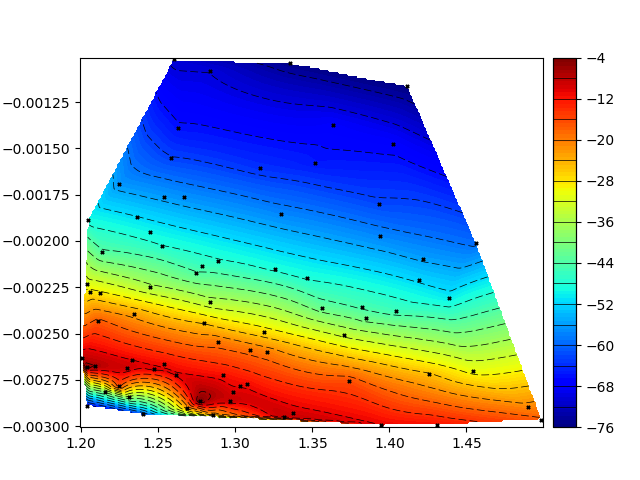

In [133]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def bin_trials(x_width, y_width, data):
    X = [_[2][0] for _ in data]
    Y = [_[2][1] for _ in data]
    Z = [-np.sqrt(_[0]) for _ in data]
    
    x_min, x_max = min(X), max(X)
    y_min, y_max = min(Y), max(Y)
    
    Xi = np.linspace(x_min-x_width, x_max+x_width, int((x_max-x_min)//x_width)+2)
    Yi = np.linspace(y_min-y_width, y_max+y_width, int((y_max-y_min)//y_width)+2)
    
    Zi = griddata(X, Y, Z, Xi, Yi, interp='nn')

    fig, ax = plt.subplots()
    CS = ax.contourf(Xi, Yi, Zi, 100, cmap=plt.cm.jet)
    DS = ax.contour(Xi, Yi, Zi, 20, linewidths=0.5, colors='k')
    ax.scatter(X, Y, marker='x', c='black', s=5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(CS, cax=cax, orientation='vertical')
    fig.colorbar(DS, cax=cax, orientation='vertical')
    plt.show()

bin_trials(0.001, 0.00001, new_tried)

<IPython.core.display.Javascript object>


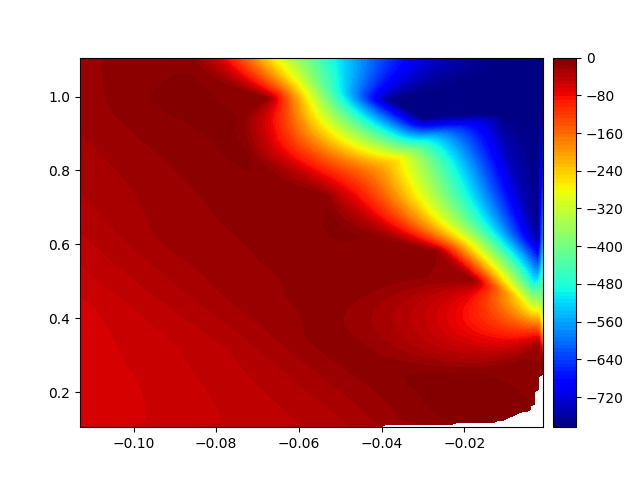

In [121]:
bin_trials(0.001, 0.005, tried)

<IPython.core.display.Javascript object>


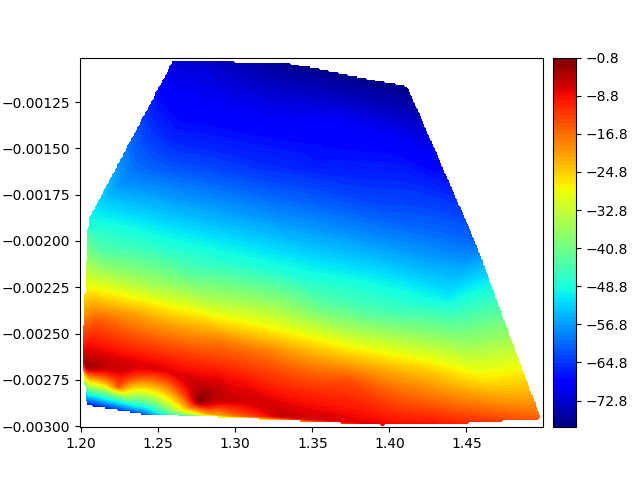

In [126]:
bin_trials(0.001, 0.00001, new_tried)

In [137]:
tried = sorted([x for x in tried if not np.isinf(x[0])], key=lambda x: x[0])
tried[:50]

[(115.51511691079531,
  (2.520343102514744, 99.1234540939331),
  (2.6079079136252403, 99.99998807907104),
  (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833)),
 (118.30784286706765,
  (2.653534896671772, 99.24623966217041),
  (2.4325260892510414, 99.99998807907104),
  (-0.09743828215520212, 0.16463693081483785, -0.31540207115383867)),
 (121.08460805522864,
  (2.7207842096686363, 99.29634928703308),
  (2.606680244207382, 99.99998807907104),
  (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841)),
 (121.58551422459173,
  (2.560114488005638, 99.16958212852478),
  (2.1950533613562584, 99.99998807907104),
  (-0.09945202514881966, 0.1530786086500896, -0.3628888603509054)),
 (122.19782045309057,
  (2.6952624320983887, 99.2656946182251),
  (2.2846681997179985, 99.99998807907104),
  (-0.09251199099189, 0.14415218760810578, -0.3651481447260706)),
 (122.88051656094223,
  (2.7372734621167183, 99.29201006889343),
  (2.681322395801544, 99.99998807907104),
  (-0.091299891669

<IPython.core.display.Javascript object>


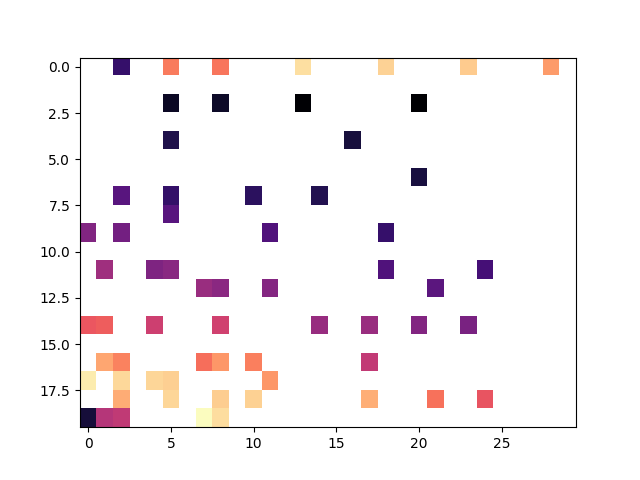

1.2002888224563926 1.4985423729771947
-0.002995171251658714 -0.0010202609406233833
(20, 30)


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [99]:
def bin_trials(x_width, y_width, data):
    X = [_[2][0] for _ in data]
    Y = [_[2][1] for _ in data]
    Z = [_[0] for _ in data]
    
    x_min, x_max = min(X), max(X)
    y_min, y_max = min(Y), max(Y)
    
    print(x_min, x_max)
    print(y_min, y_max)

    plane = np.zeros((int((y_max-y_min)//y_width)+1, int((x_max-x_min)//x_width)+1), dtype=float)
    num_trials = np.zeros(plane.shape)
    print(plane.shape)
    
    for i in range(len(X)):
        x_bin = x_width * ((X[i]-x_min) // x_width)
        y_bin = y_width * ((Y[i]-y_min) // y_width)
        _i = int(y_bin // y_width)
        _j = int(x_bin // x_width)
        plane[-_i, _j] += -np.sqrt(Z[i])
        num_trials[-_i, _j] += 1

    plane = plane / num_trials
    return plane

import matplotlib
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='red')
fig, ax = plt.subplots()
ax.imshow(bin_trials(0.01, 0.0001, new_tried), aspect='auto', cmap=plt.get_cmap('magma'))
# extent=(0, bound_x, 0, bound_y), cmap=plt.get_cmap('magma')